In [1]:
import numpy as np
import os
import cv2
from sklearn.utils import shuffle
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import gc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, MobileNet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
import kagglehub
import seaborn as sns
import pandas as pd
import skimage
from skimage.transform import resize
from sklearn.metrics import classification_report, confusion_matrix
import os
from glob import glob
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2025-05-14 22:04:30.712082: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747260270.902470      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747260270.958704      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Download latest version
path = kagglehub.dataset_download("grassknoted/asl-alphabet")
print(path)
train_path = os.path.join(path, '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train')

/kaggle/input/asl-alphabet


In [3]:
def plot_three_samples(letter):
    letter = letter.upper()
    print("Samples images for letter " + letter)
    img_path = os.path.join(train_path, letter, '*.jpg')
    path_contents = glob(img_path)
    
    if len(path_contents) < 3:
        print(f"Not enough images found for letter {letter}")
        return
    
    plt.figure(figsize=(16,16))
    imgs = random.sample(path_contents, 3)
    plt.subplot(131)
    plt.imshow(cv2.imread(imgs[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(imgs[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(imgs[2]))
    plt.show()

Samples images for letter B


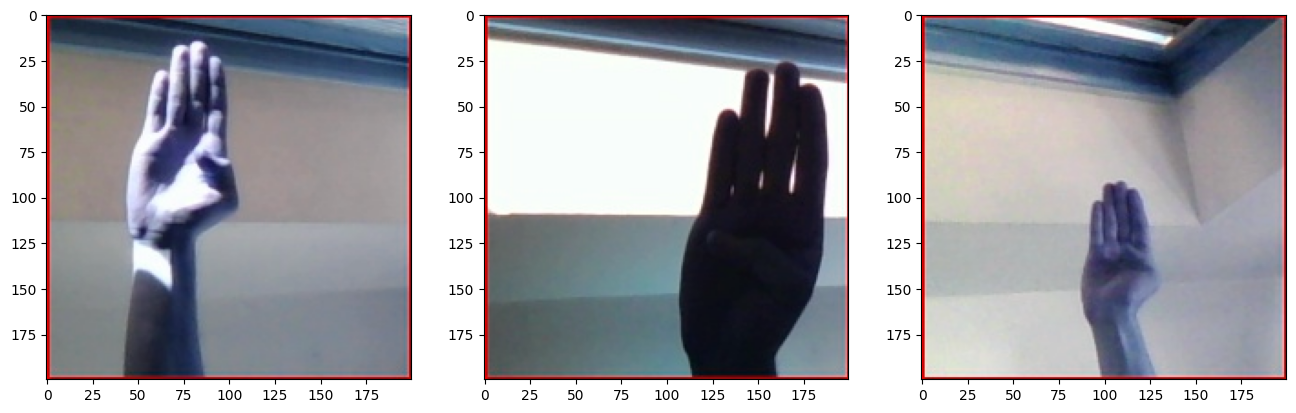

In [4]:
plot_three_samples('b')

In [5]:
# Check for GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# List all physical devices
tf.config.list_physical_devices()

# Verify TensorFlow is using GPU
tf.test.is_gpu_available()

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print("GPU configured successfully")
    except RuntimeError as e:
        print("Error configuring GPU:", e)

Num GPUs Available:  1
GPU configured successfully


I0000 00:00:1747260285.312293      19 gpu_device.cc:2022] Created device /device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [6]:
target_size = (64, 64)
target_dims = (64, 64, 3)
n_classes = 29
val_frac = 0.1
batch_size = 256

# Enhanced data augmentation
data_augmentor = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    rescale=1./255,
    validation_split=val_frac,
    brightness_range=[0.9, 1.1],
    samplewise_center=True,
    samplewise_std_normalization=True,
)

In [7]:
train_gen = data_augmentor.flow_from_directory(train_path, target_size=target_size, batch_size=256, shuffle=True, subset='training')

val_gen = data_augmentor.flow_from_directory(train_path, target_size=target_size, batch_size=256, subset='validation')

Found 78300 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.


In [8]:
model = Sequential([
    Conv2D(32, kernel_size=3, activation='relu', strides=1, input_shape=(64, 64, 3)), 
    BatchNormalization(),
    Conv2D(32, kernel_size=3, activation='relu', strides=2, input_shape=(64, 64, 3)),
    Dropout(0.5),

    Conv2D(64, kernel_size=3, strides=1, activation='relu'),
    BatchNormalization(),
    Conv2D(64, kernel_size=3, strides=2, activation='relu'),
    Dropout(0.5),
    
    Conv2D(128, strides=1, kernel_size=3, activation='relu'),
    BatchNormalization(),
    Conv2D(128, strides=2, kernel_size=3, activation='relu'),

    GlobalAveragePooling2D(),
    Dropout(0.5),

    Dense(128, activation='relu'),
    
    Dense(29, activation='softmax'),
])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1747260327.681874      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 62, 62, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 30, 30, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 11, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 11, 11, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 5, 5, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 29)                  │           3,741 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 308,157 (1.18 MB)

 Trainable params: 307,709 (1.17 MB)

 Non-trainable params: 448 (1.75 KB)

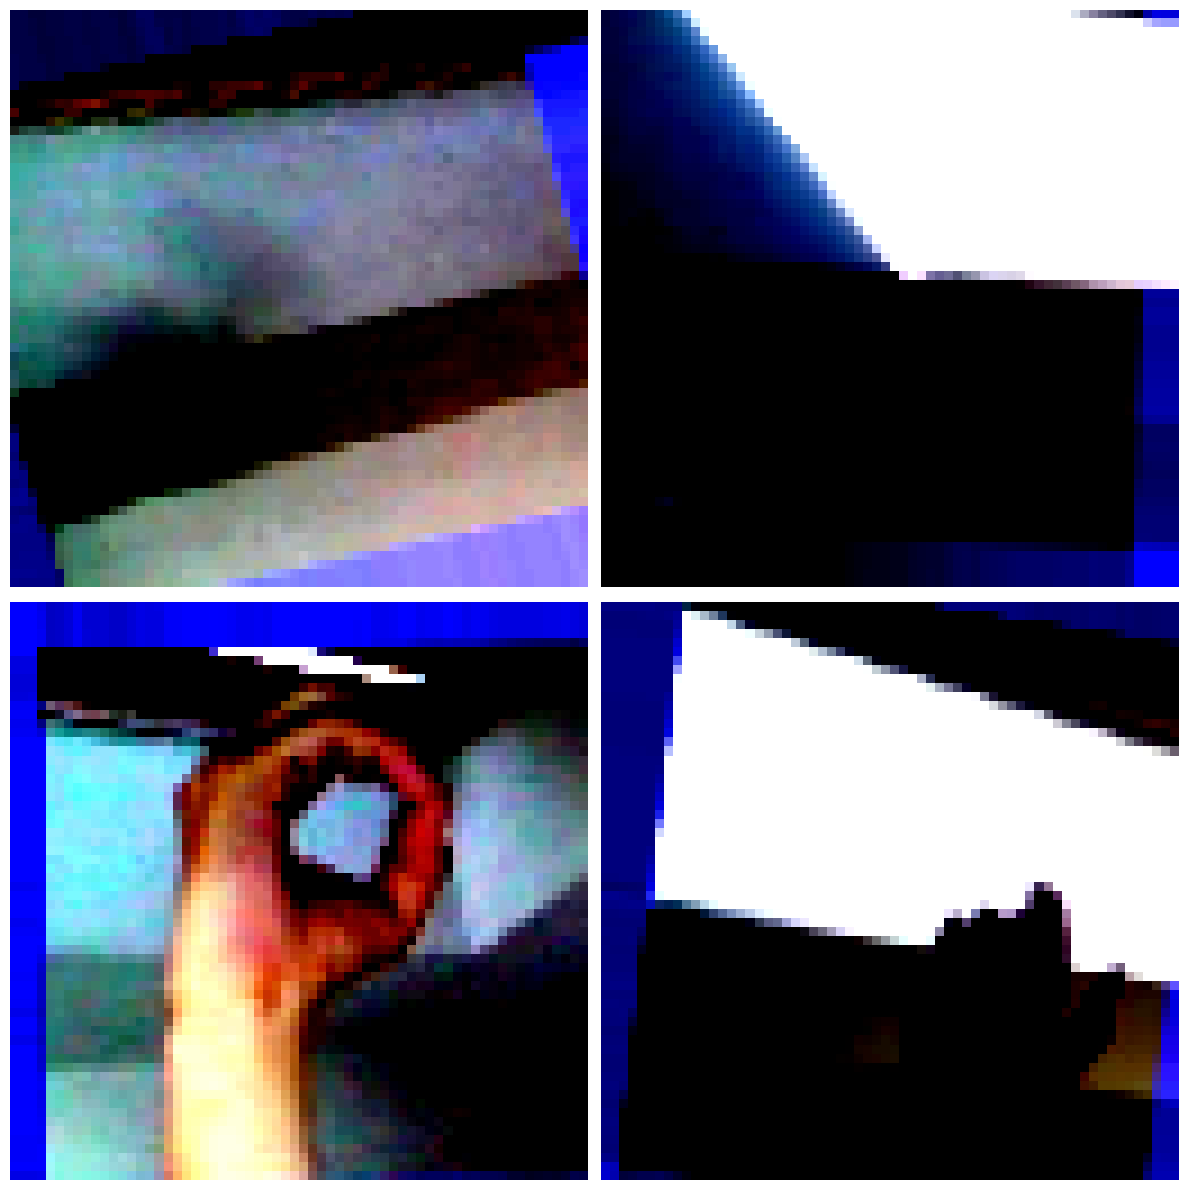

In [9]:
augmented_images, labels = next(train_gen)

def show_augmented_images(images, nrows=4, ncols=4):
    plt.figure(figsize=(12, 12))
    for i in range(nrows*ncols):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_augmented_images(augmented_images, 2, 2)

In [10]:
model.compile(
    optimizer= Adam(learning_rate= 0.001),
    loss= 'categorical_crossentropy',
    metrics= ['accuracy']
)

In [11]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs= 10,
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1747260351.754629      74 service.cc:148] XLA service 0x7d5b8c096490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747260351.755562      74 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747260352.349197      74 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/306 ━━━━━━━━━━━━━━━━━━━━ 2:07:49 25s/step - accuracy: 0.0312 - loss: 3.5429

I0000 00:00:1747260358.357412      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


306/306 ━━━━━━━━━━━━━━━━━━━━ 580s 2s/step - accuracy: 0.2083 - loss: 2.6924 - val_accuracy: 0.3253 - val_loss: 2.2450
Epoch 2/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 252s 808ms/step - accuracy: 0.7532 - loss: 0.7234 - val_accuracy: 0.8472 - val_loss: 0.4235
Epoch 3/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 225s 721ms/step - accuracy: 0.8673 - loss: 0.3912 - val_accuracy: 0.8851 - val_loss: 0.3250
Epoch 4/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 224s 716ms/step - accuracy: 0.9056 - loss: 0.2766 - val_accuracy: 0.9159 - val_loss: 0.2625
Epoch 5/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 223s 714ms/step - accuracy: 0.9256 - loss: 0.2254 - val_accuracy: 0.9330 - val_loss: 0.2067
Epoch 6/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 223s 713ms/step - accuracy: 0.9396 - loss: 0.1822 - val_accuracy: 0.9343 - val_loss: 0.2182
Epoch 7/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 226s 724ms/step - accuracy: 0.9489 - loss: 0.1604 - val_accuracy: 0.9507 - val_loss: 0.1557
Epoch 8/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 223s 713ms/step - accuracy: 0.9538 - loss: 0.1434 